# Lab 6 - Pattern Mining

Pattern Mining in a method used to find patterns, associations, correlations or causal structures among set of items. Therefore, it will be used to generate some rules for us to analyse, the number of features and bins (cut and qcut discretization) and vary.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd, numpy as np
# from mlxtend.frequent_patterns import apriori, association_rules #for ARM
# from sklearn.feature_selection import SelectKBest, f_classif
from utils import graphFunctions as graph
import matplotlib.pyplot as plt
from utils import modelAnalyzesFunctions as analyzes

In [21]:
data: pd.DataFrame = pd.read_csv('../datasets/covtype_data_preparation.csv', sep=',', decimal='.')

aux = []
qtd_soil_types = 40
for i in range(qtd_soil_types):
    aux.append('Soil_Type-'+str(i+1))

aux2 = []
qtd_wilderness_areas = 4
for i in range(qtd_wilderness_areas):
    aux2.append('Wilderness_Area-'+str(i+1))

binary_types = aux + aux2
binary_types.append('Cover_Type')
convert_dict = {}
for col in binary_types:
    convert_dict[col] = 'category'
analysis = data.astype(convert_dict)

df_target = analysis.iloc[:, analysis.shape[1]-1]
y: np.ndarray = analysis.pop('Cover_Type').values
X: np.ndarray = analysis.values
labels = pd.unique(y)

analysis.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type-31,Soil_Type-32,Soil_Type-33,Soil_Type-34,Soil_Type-35,Soil_Type-36,Soil_Type-37,Soil_Type-38,Soil_Type-39,Soil_Type-40
0,0.546773,0.200000,0.454545,0.047960,0.272610,0.367290,0.937008,0.665354,0.161417,0.308518,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.637819,0.891667,0.090909,0.064424,0.223514,0.105381,0.803150,0.921260,0.665354,0.158929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.716858,0.163889,0.287879,0.125268,0.232558,0.593790,0.905512,0.771654,0.354331,0.500209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.549775,0.133333,0.106061,0.021475,0.228682,0.437544,0.877953,0.885827,0.543307,0.157814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.699850,0.519444,0.121212,0.336435,0.295866,0.360264,0.870079,0.968504,0.625984,0.191552,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from mlxtend.frequent_patterns import apriori, association_rules

def apriori_rules(dummified_df, minpaterns=10, minconf=0.9, minlengthrule=2, minsup=1):
    frequent_itemsets = {}
    while minsup>0:
        minsup = minsup*0.9
        frequent_itemsets = apriori(dummified_df, min_support=minsup, use_colnames=True)
        if len(frequent_itemsets) >= minpaterns:
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=minconf)
            rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
            if (len(rules[(rules['antecedent_len']>=minlengthrule)]) >= minpaterns):
                break
    patterns = len(frequent_itemsets)
    bigger_patterns = len(rules[(rules['antecedent_len']>=2)])
    avg_support = rules[(rules['antecedent_len']>=2)]['support'].mean()
    avg_confidence = rules[(rules['antecedent_len']>=2)]['confidence'].mean()
    avg_leverage = rules[(rules['antecedent_len']>=2)]['leverage'].mean()
    avf_lift = rules[(rules['antecedent_len']>=2)]['lift'].mean()
    return [patterns, bigger_patterns, avg_support, avg_confidence, avg_leverage, avf_lift], rules[(rules['antecedent_len']>=minlengthrule)]

def pattern_mining_analyzes(data, df_target, num_features, num_bins, metrics):
    y: np.ndarray = df_target.values
    X: np.ndarray = data.values

    results_cut = np.zeros((len(num_features), len(num_bins), len(metrics)))
    results_qcut = np.zeros((len(num_features), len(num_bins), len(metrics)))

    for k in range(len(num_features)):
        for bins in range(len(num_bins)):
            selector = SelectKBest(mutual_info_classif, k=num_features[k])
            X_new = selector.fit_transform(X, y)

            cols = selector.get_support(indices=True)

            selected_df = data.iloc[:, cols].join(df_target)
            selected_df.head()
            newdf_cut = selected_df.copy()
            newdf_qcut = selected_df.copy()
            for col in newdf_cut:
                if (col not in ['class'] and newdf_cut[col].dtype.name != 'category'):
                    ## Discretize according to the size of the bins
                    newdf_cut[col] = pd.cut(newdf_cut[col],num_bins[bins],labels=range(num_bins[bins]))
                    ## Discretize according to the number of the elements per bins (similar to quartiles)
                    newdf_qcut[col] = pd.qcut(newdf_qcut[col],num_bins[bins],labels=range(num_bins[bins]))
            dummylist_cut = []
            dummylist_qcut = []
            for att in newdf_cut:
                if (att in ['class', 'gender']): newdf_cut[att] = newdf_cut[att].astype('category')
                if (att in ['class', 'gender']): newdf_qcut[att] = newdf_qcut[att].astype('category')
                dummylist_cut.append(pd.get_dummies(newdf_cut[[att]]))
                dummylist_qcut.append(pd.get_dummies(newdf_qcut[[att]]))
            dummified_df_cut = pd.concat(dummylist_cut, axis=1)
            dummified_df_qcut = pd.concat(dummylist_qcut, axis=1)

            results_cut[k, bins], rules_cut = apriori_rules(dummified_df_cut)
            results_qcut[k, bins], rules_qcut = apriori_rules(dummified_df_qcut)

    plot_results_cut = {}
    plot_results_qcut = {}
    for m in range(len(metrics)):
        plot_results_cut[m] = {}
        plot_results_qcut[m] = {}
        for n in range(len(num_bins)):
            plot_results_cut[m][num_bins[n]] = results_cut[:, n, m]
            plot_results_qcut[m][num_bins[n]] = results_qcut[:, n, m]

    fig, axs = plt.subplots(len(metrics), 2, figsize=(len(metrics)*3, 26))
    plt.subplots_adjust(hspace=0.3)
    for m in range(len(metrics)):
        graph.multiple_line_chart(axs[m, 0], num_features, plot_results_cut[m], "Cut - " + metrics[m] + " by number of features and number of bins", "Number of features", metrics[m])
        graph.multiple_line_chart(axs[m, 1], num_features, plot_results_qcut[m], "Qcut - " + metrics[m] + " by number of features and number of bins", "Number of features", metrics[m])
    return results_cut, results_qcut

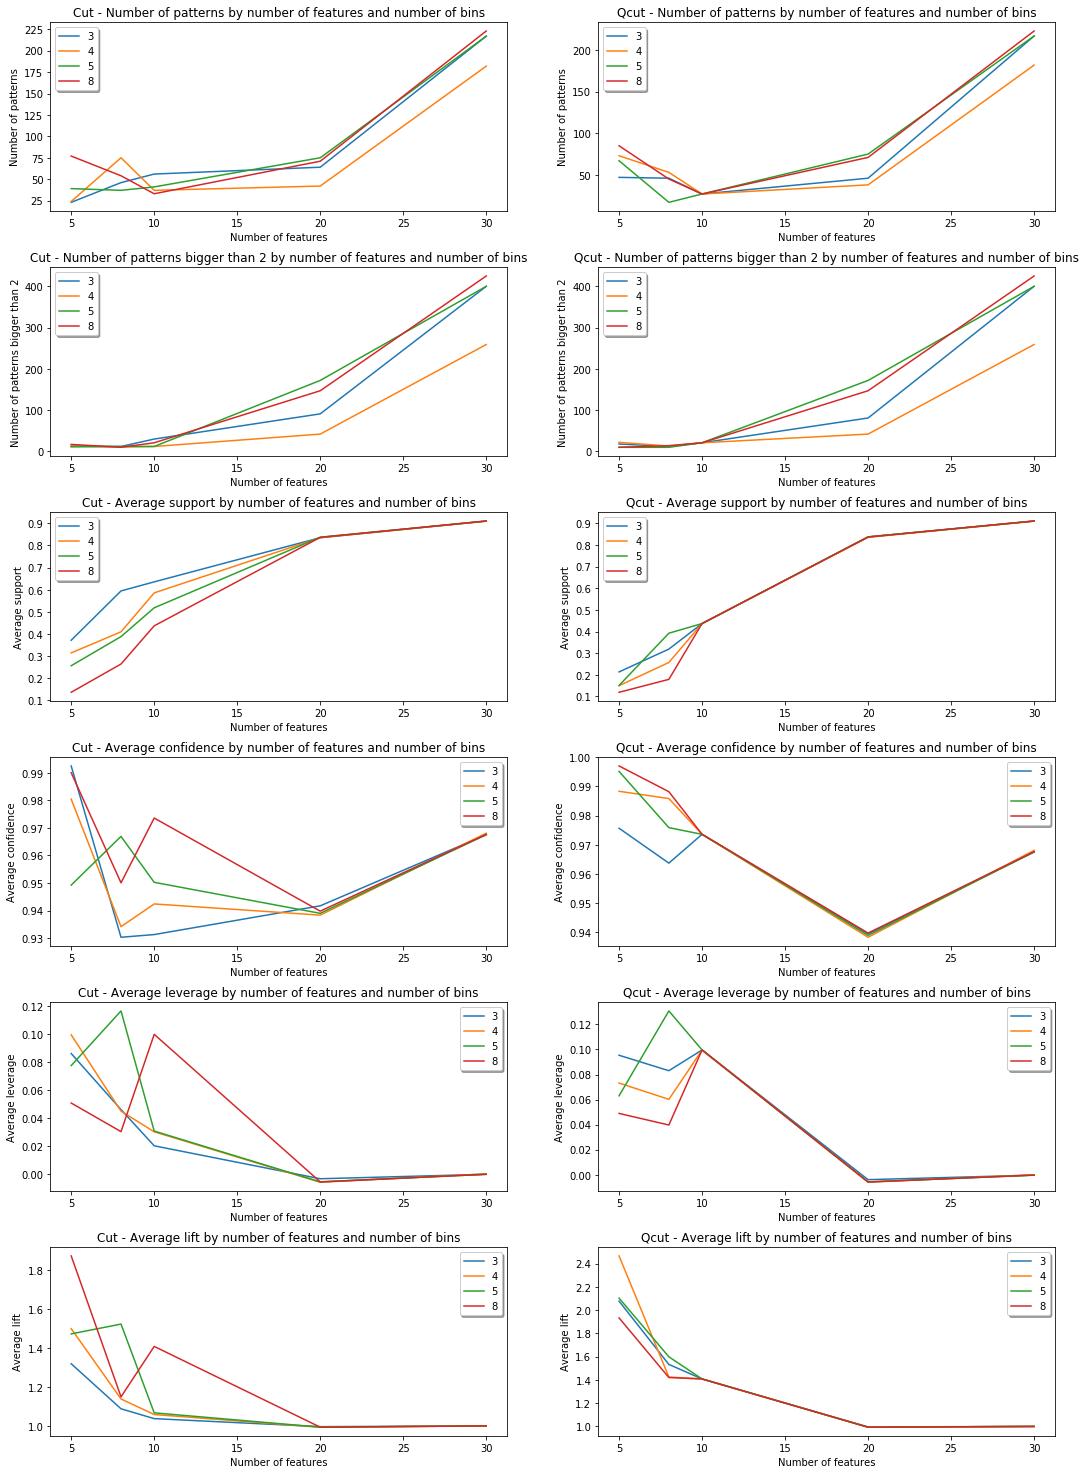

In [5]:
num_features = [5, 8, 10, 20, 30]
num_bins = [3, 4, 5, 8]
metrics = ["Number of patterns", "Number of patterns bigger than 2", "Average support", "Average confidence", "Average leverage", "Average lift"]

results_cut, results_qcut, rules_cut, rules_qcut = pattern_mining_analyzes(analysis, df_target, num_features, num_bins, metrics)

## Fixing one value to evaluate the rules

In [12]:
selector = SelectKBest(mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

cols = selector.get_support(indices=True)

selected_df = analysis.iloc[:, cols].join(df_target)
selected_df.head()

,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Horizontal_Distance_To_Fire_Points,Wilderness_Area-1,Wilderness_Area-3,Wilderness_Area-4,Soil_Type-3,Soil_Type-10,Cover_Type
0,0.546773,0.047960,0.367290,0.937008,0.308518,0.0,1.0,0.0,0.0,0.0,1
1,0.637819,0.064424,0.105381,0.803150,0.158929,0.0,0.0,0.0,0.0,0.0,1
2,0.716858,0.125268,0.593790,0.905512,0.500209,0.0,1.0,0.0,0.0,0.0,1
3,0.549775,0.021475,0.437544,0.877953,0.157814,0.0,1.0,0.0,0.0,0.0,1
4,0.699850,0.336435,0.360264,0.870079,0.191552,0.0,1.0,0.0,0.0,0.0,1


## Discretize according to the number of the elements per bins (similar to quartiles)

In [13]:
n_bins = 4

newdf_qcut = selected_df.copy()
for col in newdf_qcut:
    if (col not in ['class'] and newdf_qcut[col].dtype.name != 'category'):
        newdf_qcut[col] = pd.qcut(newdf_qcut[col],n_bins,labels=range(n_bins))
newdf_qcut.head()

,Elevation,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Horizontal_Distance_To_Fire_Points,Wilderness_Area-1,Wilderness_Area-3,Wilderness_Area-4,Soil_Type-3,Soil_Type-10,Cover_Type
0,2,0,3,3,3,0.0,1.0,0.0,0.0,0.0,1
1,3,1,0,1,1,0.0,0.0,0.0,0.0,0.0,1
2,3,1,3,2,3,0.0,1.0,0.0,0.0,0.0,1
3,2,0,3,2,1,0.0,1.0,0.0,0.0,0.0,1
4,3,3,3,2,2,0.0,1.0,0.0,0.0,0.0,1


## Dummify attributes

In [14]:
dummylist_qcut = []
for att in newdf_qcut:
    if (att in ['class', 'gender']): newdf_qcut[att] = newdf_qcut[att].astype('category')
    dummylist_qcut.append(pd.get_dummies(newdf_qcut[[att]]))
dummified_df_qcut = pd.concat(dummylist_qcut, axis=1)
dummified_df_qcut.head()

,Elevation_0,Elevation_1,Elevation_2,Elevation_3,Horizontal_Distance_To_Hydrology_0,Horizontal_Distance_To_Hydrology_1,Horizontal_Distance_To_Hydrology_2,Horizontal_Distance_To_Hydrology_3,Horizontal_Distance_To_Roadways_0,Horizontal_Distance_To_Roadways_1,...,Soil_Type-3_1.0,Soil_Type-10_0.0,Soil_Type-10_1.0,Cover_Type_1,Cover_Type_2,Cover_Type_3,Cover_Type_4,Cover_Type_5,Cover_Type_6,Cover_Type_7
0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,0,0,1,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0


In [16]:
apriori_rules(dummified_df_qcut)[1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
7,"(Wilderness_Area-3_1.0, Wilderness_Area-1_0.0)",(Wilderness_Area-4_0.0),0.418847,0.690416,0.418847,1.000000,1.448403,0.129668,inf,2
8,"(Wilderness_Area-3_1.0, Wilderness_Area-4_0.0)",(Wilderness_Area-1_0.0),0.418847,0.759946,0.418847,1.000000,1.315883,0.100546,inf,2
9,"(Wilderness_Area-1_0.0, Wilderness_Area-4_0.0)",(Wilderness_Area-3_1.0),0.450361,0.418847,0.418847,0.930023,2.220439,0.230214,8.304932,2
11,"(Wilderness_Area-3_1.0, Wilderness_Area-1_0.0)",(Soil_Type-3_0.0),0.418847,0.936450,0.414270,0.989074,1.056195,0.022041,5.816255,2
12,"(Wilderness_Area-3_1.0, Soil_Type-3_0.0)",(Wilderness_Area-1_0.0),0.414270,0.759946,0.414270,1.000000,1.315883,0.099447,inf,2
14,"(Wilderness_Area-1_0.0, Wilderness_Area-4_0.0)",(Soil_Type-3_0.0),0.450361,0.936450,0.445785,0.989838,1.057011,0.024044,6.253883,2
15,"(Wilderness_Area-1_0.0, Wilderness_Area-4_0.0)",(Soil_Type-10_0.0),0.450361,0.859483,0.407978,0.905889,1.053993,0.020900,1.493100,2
16,"(Wilderness_Area-3_1.0, Wilderness_Area-4_0.0)",(Soil_Type-3_0.0),0.418847,0.936450,0.414270,0.989074,1.056195,0.022041,5.816255,2
17,"(Wilderness_Area-3_1.0, Soil_Type-3_0.0)",(Wilderness_Area-4_0.0),0.414270,0.690416,0.414270,1.000000,1.448403,0.128252,inf,2
19,"(Soil_Type-10_0.0, Wilderness_Area-4_0.0)",(Soil_Type-3_0.0),0.648032,0.936450,0.643455,0.992938,1.060321,0.036606,8.998803,2


The Wilderness_Area and Soil_Type attributes didn't help much on the patterns, therefore we will run again without them (using instead the first 10 features of the dataset).

In [39]:
selected_df = analysis.iloc[:, 0:10].join(df_target)

n_bins = 4

newdf_qcut = selected_df.copy()
for col in newdf_qcut:
    if (col not in ['class'] and newdf_qcut[col].dtype.name != 'category'):
        newdf_qcut[col] = pd.qcut(newdf_qcut[col],n_bins,labels=range(n_bins))
newdf_qcut.head()

dummylist_qcut = []
for att in newdf_qcut:
    if (att in ['class', 'gender']): newdf_qcut[att] = newdf_qcut[att].astype('category')
    dummylist_qcut.append(pd.get_dummies(newdf_qcut[[att]]))
dummified_df_qcut = pd.concat(dummylist_qcut, axis=1)
dummified_df_qcut.head()

results = np.zeros(len(metrics))

results, rules = apriori_rules(dummified_df_qcut)
for m in range(len(metrics)):
    print(metrics[m],":", results[m])
rules

Number of patterns : 174
Number of patterns bigger than 2 : 15
Average support : 0.08968745124551458
Average confidence : 0.9623995120219979
Average leverage : 0.06741920214015765
Average lift : 4.111349324721345


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
2,"(Horizontal_Distance_To_Hydrology_0, Cover_Typ...",(Elevation_0),0.087992,0.250663,0.084144,0.956265,3.814941,0.062087,17.133488,2
3,"(Cover_Type_7, Horizontal_Distance_To_Roadways_3)",(Elevation_3),0.085704,0.249467,0.085548,0.998180,4.001250,0.064168,412.292822,2
4,"(Aspect_1, Hillshade_Noon_0)",(Hillshade_9am_3),0.090748,0.239170,0.083884,0.924355,3.864846,0.062179,10.057942,2
5,"(Hillshade_Noon_0, Hillshade_9am_3)",(Aspect_1),0.088044,0.248999,0.083884,0.952747,3.826308,0.061961,15.893061,2
6,"(Aspect_1, Hillshade_3pm_0)",(Hillshade_9am_3),0.153570,0.239170,0.144573,0.941416,3.936177,0.107844,12.986884,2
7,"(Aspect_1, Hillshade_Noon_0)",(Hillshade_3pm_0),0.090748,0.256020,0.090748,1.000000,3.905952,0.067515,inf,2
8,"(Aspect_2, Hillshade_3pm_2)",(Hillshade_Noon_3),0.080971,0.247699,0.080971,1.000000,4.037161,0.060915,inf,2
9,"(Horizontal_Distance_To_Hydrology_0, Slope_0)",(Vertical_Distance_To_Hydrology_0),0.098549,0.255500,0.090540,0.918734,3.595833,0.065361,9.161224,2
10,"(Slope_3, Hillshade_9am_3)",(Hillshade_3pm_0),0.094493,0.256020,0.093557,0.990094,3.867258,0.069365,75.100693,2
11,"(Hillshade_Noon_0, Hillshade_9am_3)",(Hillshade_3pm_0),0.088044,0.256020,0.088044,1.000000,3.905952,0.065503,inf,2


In [47]:
selected_df = analysis.iloc[:, 0:10].join(df_target)

n_bins = 8

newdf_qcut = selected_df.copy()
for col in newdf_qcut:
    if (col not in ['class'] and newdf_qcut[col].dtype.name != 'category'):
        newdf_qcut[col] = pd.qcut(newdf_qcut[col],n_bins,labels=range(n_bins))
newdf_qcut.head()

dummylist_qcut = []
for att in newdf_qcut:
    if (att in ['class', 'gender']): newdf_qcut[att] = newdf_qcut[att].astype('category')
    dummylist_qcut.append(pd.get_dummies(newdf_qcut[[att]]))
dummified_df_qcut = pd.concat(dummylist_qcut, axis=1)
dummified_df_qcut.head()

results = np.zeros(len(metrics))

results, rules = apriori_rules(dummified_df_qcut)
for m in range(len(metrics)):
    print(metrics[m],":", results[m])
rules

Number of patterns : 274
Number of patterns bigger than 2 : 13
Average support : 0.04154782239966077
Average confidence : 0.963469850487075
Average leverage : 0.03540877989180018
Average lift : 7.0268511840990175


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,"(Elevation_0, Vertical_Distance_To_Hydrology_0)",(Horizontal_Distance_To_Hydrology_0),0.045712,0.183889,0.042956,0.939704,5.110173,0.034550,13.535125,2
1,"(Elevation_7, Horizontal_Distance_To_Roadways_7)",(Cover_Type_7),0.037391,0.142857,0.033959,0.908206,6.357441,0.028617,9.337662,2
2,"(Horizontal_Distance_To_Fire_Points_7, Elevati...",(Cover_Type_7),0.035363,0.142857,0.032243,0.911765,6.382353,0.027191,9.714286,2
3,"(Aspect_3, Hillshade_3pm_0)",(Hillshade_9am_7),0.046440,0.114046,0.046284,0.996641,8.738897,0.040988,263.718827,2
4,"(Hillshade_9am_5, Hillshade_Noon_6)",(Aspect_4),0.034011,0.126372,0.033231,0.977064,7.731674,0.028933,38.090197,2
5,"(Aspect_5, Hillshade_3pm_6)",(Hillshade_Noon_7),0.039576,0.117427,0.037391,0.944809,8.045944,0.032744,15.991386,2
6,"(Hillshade_Noon_7, Hillshade_3pm_6)",(Aspect_5),0.037599,0.123459,0.037391,0.994467,8.055019,0.032749,158.434721,2
7,"(Hillshade_9am_0, Aspect_6)",(Hillshade_3pm_7),0.065890,0.119767,0.064642,0.981058,8.191384,0.056750,46.468966,2
8,"(Slope_7, Hillshade_9am_7)",(Hillshade_3pm_0),0.037391,0.127100,0.037183,0.994437,7.824069,0.032431,156.903830,2
9,"(Cover_Type_4, Vertical_Distance_To_Hydrology_0)",(Horizontal_Distance_To_Hydrology_0),0.063342,0.183889,0.062354,0.984401,5.353235,0.050706,52.317016,2


In [51]:
selected_df = analysis.iloc[:, 0:10].join(df_target)

n_bins = 9

newdf_qcut = selected_df.copy()
for col in newdf_qcut:
    if (col not in ['class'] and newdf_qcut[col].dtype.name != 'category'):
        newdf_qcut[col] = pd.qcut(newdf_qcut[col],n_bins,labels=range(n_bins))
newdf_qcut.head()

dummylist_qcut = []
for att in newdf_qcut:
    if (att in ['class', 'gender']): newdf_qcut[att] = newdf_qcut[att].astype('category')
    dummylist_qcut.append(pd.get_dummies(newdf_qcut[[att]]))
dummified_df_qcut = pd.concat(dummylist_qcut, axis=1)
dummified_df_qcut.head()

results = np.zeros(len(metrics))

results, rules = apriori_rules(dummified_df_qcut)
for m in range(len(metrics)):
    print(metrics[m],":", results[m])
rules

Number of patterns : 368
Number of patterns bigger than 2 : 13
Average support : 0.03345907823519764
Average confidence : 0.968221802335361
Average leverage : 0.028568687916771314
Average lift : 7.4479961060409225


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,"(Elevation_0, Vertical_Distance_To_Hydrology_0)",(Horizontal_Distance_To_Hydrology_0),0.041240,0.183889,0.038640,0.936948,5.095186,0.031056,12.943522,2
1,"(Elevation_4, Horizontal_Distance_To_Roadways_0)",(Cover_Type_5),0.028239,0.142857,0.027251,0.965009,6.755064,0.023216,24.496241,2
2,"(Elevation_8, Horizontal_Distance_To_Roadways_8)",(Cover_Type_7),0.027875,0.142857,0.026574,0.953358,6.673507,0.022592,18.377143,2
3,"(Horizontal_Distance_To_Fire_Points_8, Elevati...",(Cover_Type_7),0.029643,0.142857,0.027823,0.938596,6.570175,0.023588,13.959184,2
4,"(Aspect_2, Hillshade_Noon_0)",(Hillshade_3pm_0),0.028239,0.112382,0.027251,0.965009,8.586840,0.024077,25.367178,2
5,"(Aspect_3, Hillshade_3pm_0)",(Hillshade_9am_8),0.036663,0.101305,0.035519,0.968794,9.563114,0.031805,28.799080,2
6,"(Aspect_4, Hillshade_3pm_0)",(Hillshade_9am_8),0.029123,0.101305,0.028343,0.973214,9.606744,0.025392,33.551268,2
7,"(Hillshade_3pm_7, Hillshade_Noon_8)",(Aspect_6),0.032191,0.111342,0.032191,1.000000,8.981317,0.028607,inf,2
8,"(Hillshade_Noon_8, Hillshade_3pm_8)",(Aspect_6),0.027563,0.111342,0.027563,1.000000,8.981317,0.024494,inf,2
9,"(Slope_8, Hillshade_9am_8)",(Hillshade_3pm_0),0.030059,0.112382,0.029799,0.991349,8.821221,0.026421,102.608602,2
